In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

os.makedirs("results/figures", exist_ok=True)
os.makedirs("results/metrics", exist_ok=True)
os.makedirs("models", exist_ok=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Run on Mac
print("Device:", device)

Device: mps


In [4]:
adata = sc.datasets.pbmc3k_processed()

label_col = "louvain"   # change if you have 'cell_type'
adata.obs[label_col] = adata.obs[label_col].astype(str)

print(adata)
print(adata.obs[label_col].value_counts())

X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()
X = X.astype(np.float32)

classes = sorted(adata.obs[label_col].unique())
class_to_int = {c:i for i,c in enumerate(classes)}
y = adata.obs[label_col].map(class_to_int).values.astype(np.int64)

print("X:", X.shape, "n_classes:", len(classes))

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
louvain
CD4 T cells          1144
CD14+ Monocytes       480
B cells               342
CD8 T cells           316
NK cells              154
FCGR3A+ Monocytes     150
Dendritic cells        37
Megakaryocytes         15
Name: count, dtype: int64
X: (2638, 1838) n_classes: 8


In [6]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=0, stratify=y_tmp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1846, 1838) Val: (396, 1838) Test: (396, 1838)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Simple baseline
lr = LogisticRegression(max_iter=1000, random_state=0)
lr.fit(X_train, y_train)
print(f"Logistic Regression Test Acc: {lr.score(X_test, y_test):.3f}")

Logistic Regression Test Acc: 0.957


In [10]:
K = 128  # sequence length (keep small for CPU)
n_genes = X.shape[1]

def make_topk_sequences(X_np, K=128):
    # returns gene_ids: (N,K) and gene_vals: (N,K)
    gene_ids = np.argsort(-X_np, axis=1)[:, :K]  # top K indices
    gene_vals = np.take_along_axis(X_np, gene_ids, axis=1)
    return gene_ids.astype(np.int64), gene_vals.astype(np.float32)

train_ids, train_vals = make_topk_sequences(X_train, K)
val_ids, val_vals = make_topk_sequences(X_val, K)
test_ids, test_vals = make_topk_sequences(X_test, K)

print(train_ids.shape, train_vals.shape)

(1846, 128) (1846, 128)


In [12]:
class CellTransformer(nn.Module):
    def __init__(self, n_genes, n_classes, d_model=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1):
        super().__init__()
        self.gene_emb = nn.Embedding(n_genes, d_model)
        self.val_proj = nn.Linear(1, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_classes)
        )

    def forward(self, gene_ids, gene_vals):
        # gene_ids: (B,K), gene_vals: (B,K)
        g = self.gene_emb(gene_ids)              # (B,K,d)
        v = self.val_proj(gene_vals.unsqueeze(-1))  # (B,K,d)
        x = g + v                                # combine identity + magnitude

        h = self.encoder(x)                      # (B,K,d)

        # mean pooling across tokens
        cell_emb = h.mean(dim=1)                 # (B,d)
        logits = self.classifier(cell_emb)       # (B,C)
        return logits, cell_emb

model = CellTransformer(n_genes=n_genes, n_classes=len(classes)).to(device)
model

CellTransformer(
  (gene_emb): Embedding(1838, 128)
  (val_proj): Linear(in_features=1, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [24]:
import time

batch_size = 128
epochs = 20
lr = 3e-4

train_ds = TensorDataset(
    torch.from_numpy(train_ids), torch.from_numpy(train_vals), torch.from_numpy(y_train)
)
val_ds = TensorDataset(
    torch.from_numpy(val_ids), torch.from_numpy(val_vals), torch.from_numpy(y_val)
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

best_val = 0.0
train_hist, val_hist = [], []

t0 = time.time()  # total training timer

for epoch in range(1, epochs+1):
    epoch_start = time.time()
    model.train()
    correct, total, loss_sum = 0, 0, 0.0

    for gids, gvals, yb in train_loader:
        gids, gvals, yb = gids.to(device), gvals.to(device), yb.to(device)
        optimizer.zero_grad()
        logits, _ = model(gids, gvals)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_loss = loss_sum / total

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for gids, gvals, yb in val_loader:
            gids, gvals, yb = gids.to(device), gvals.to(device), yb.to(device)
            logits, _ = model(gids, gvals)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total

    train_hist.append(train_acc)
    val_hist.append(val_acc)

    epoch_time = time.time() - epoch_start
    speed = total / epoch_time  # samples/sec, training only


    print(f"Epoch {epoch:02d} | train_acc={train_acc:.3f} | val_acc={val_acc:.3f} | train_loss={train_loss:.3f} | " 
          f"speed={speed:.0f} samples/s")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "models/transformer_best.pt")

print("Best val acc:", best_val)
total_time = time.time() - t0
print(f"Best val acc: {best_val:.3f}")
print(f"Total training time: {total_time/60:.2f} minutes")

Epoch 01 | train_acc=0.940 | val_acc=0.866 | train_loss=0.174 | speed=282 samples/s
Epoch 02 | train_acc=0.986 | val_acc=0.894 | train_loss=0.055 | speed=339 samples/s
Epoch 03 | train_acc=0.992 | val_acc=0.899 | train_loss=0.039 | speed=347 samples/s
Epoch 04 | train_acc=0.993 | val_acc=0.896 | train_loss=0.033 | speed=347 samples/s
Epoch 05 | train_acc=0.995 | val_acc=0.899 | train_loss=0.030 | speed=324 samples/s
Epoch 06 | train_acc=0.992 | val_acc=0.904 | train_loss=0.029 | speed=340 samples/s
Epoch 07 | train_acc=0.992 | val_acc=0.902 | train_loss=0.030 | speed=340 samples/s
Epoch 08 | train_acc=0.995 | val_acc=0.891 | train_loss=0.024 | speed=331 samples/s
Epoch 09 | train_acc=0.993 | val_acc=0.889 | train_loss=0.029 | speed=334 samples/s
Epoch 10 | train_acc=0.990 | val_acc=0.886 | train_loss=0.033 | speed=340 samples/s
Epoch 11 | train_acc=0.997 | val_acc=0.907 | train_loss=0.019 | speed=345 samples/s
Epoch 12 | train_acc=0.996 | val_acc=0.902 | train_loss=0.023 | speed=345 sa

In [15]:
model.load_state_dict(torch.load("models/transformer_best.pt", map_location=device))
model.eval()

test_ds = TensorDataset(
    torch.from_numpy(test_ids), torch.from_numpy(test_vals), torch.from_numpy(y_test)
)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

preds = []
with torch.no_grad():
    for gids, gvals, yb in test_loader:
        gids, gvals = gids.to(device), gvals.to(device)
        logits, _ = model(gids, gvals)
        preds.append(logits.argmax(dim=1).cpu().numpy())
y_pred = np.concatenate(preds)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)

rep = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
pd.DataFrame(rep).T.to_csv("results/metrics/transformer_classification_report.csv")
print(classification_report(y_test, y_pred, target_names=classes))
print("Saved: results/metrics/transformer_classification_report.csv")

Test accuracy: 0.9191919191919192
                   precision    recall  f1-score   support

          B cells       0.95      1.00      0.97        52
  CD14+ Monocytes       0.89      0.93      0.91        72
      CD4 T cells       0.95      0.97      0.96       171
      CD8 T cells       0.89      0.85      0.87        47
  Dendritic cells       1.00      0.17      0.29         6
FCGR3A+ Monocytes       0.77      0.74      0.76        23
   Megakaryocytes       1.00      1.00      1.00         2
         NK cells       0.86      0.83      0.84        23

         accuracy                           0.92       396
        macro avg       0.91      0.81      0.83       396
     weighted avg       0.92      0.92      0.91       396

Saved: results/metrics/transformer_classification_report.csv


/Users/Chris/miniconda3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


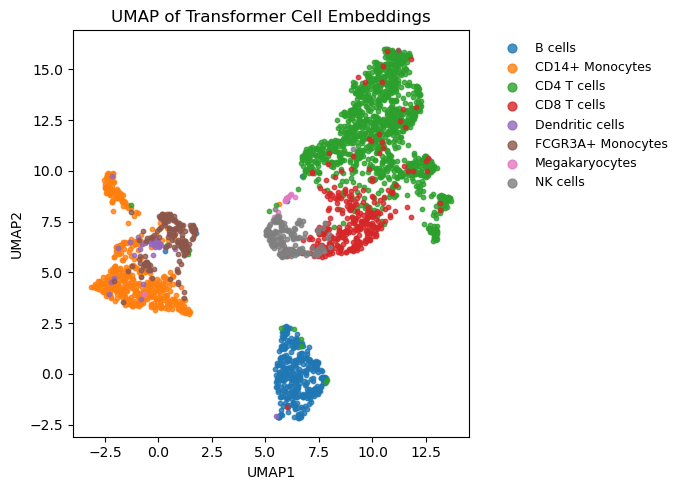

Saved: results/figures/transformer_umap.png


In [16]:
import umap

# Get embeddings for ALL cells
all_ids, all_vals = make_topk_sequences(X, K)
all_loader = DataLoader(
    TensorDataset(torch.from_numpy(all_ids), torch.from_numpy(all_vals)),
    batch_size=256,
    shuffle=False
)

embs = []
with torch.no_grad():
    for gids, gvals in all_loader:
        gids, gvals = gids.to(device), gvals.to(device)
        _, cell_emb = model(gids, gvals)
        embs.append(cell_emb.cpu().numpy())
E = np.vstack(embs)

U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)

plt.figure(figsize=(7,5))
for i, name in enumerate(classes):
    idx = (y == i)
    plt.scatter(U[idx,0], U[idx,1], s=10, alpha=0.8, label=name)

plt.title("UMAP of Transformer Cell Embeddings")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, markerscale=2)
plt.tight_layout()
plt.savefig("results/figures/transformer_umap.png", dpi=200)
plt.show()

print("Saved: results/figures/transformer_umap.png")